In [1]:
import cudf
import cupy as cp
import kvikio
import numpy as np
import pandas as pd
import time
import zarr

In [2]:
# conda install -c conda-forge zarr

In [3]:
HOST_LZ4_MAX = 2013929216 # 2113929216
sizes = list(map(lambda x: HOST_LZ4_MAX//(2**x), np.arange(20)))
print(sizes)

[2013929216, 1006964608, 503482304, 251741152, 125870576, 62935288, 31467644, 15733822, 7866911, 3933455, 1966727, 983363, 491681, 245840, 122920, 61460, 30730, 15365, 7682, 3841]


In [4]:
input_size = []
cascaded_size = []
cascaded_temp_size = []
cascaded_round_trip_time = []
lz4_gpu_size = []
lz4_gpu_temp_size = []
lz4_gpu_round_trip_time = []
bitcomp_gpu_size = []
bitcomp_gpu_temp_size = []
bitcomp_gpu_round_trip_time = []
lz4_size = []
lz4_round_trip_time = []

In [5]:
# !wget 'http://textfiles.com/etext/NONFICTION/kjv10.txt'

In [6]:
text = open('kjv10.txt').read()
bib = np.frombuffer(bytes(text, 'utf-8'), dtype=np.int8)
data_buffer = np.tile(bib, 500)

In [46]:
# One of the three below keys, this will set the arrangement of test data for a full run of the notebook.
TARGET = "Ascending"
DTYPE = cp.int32

In [52]:
data = {
    "Ascending": np.arange(0, HOST_LZ4_MAX, dtype=np.int32),
    "Random": np.random.randint(0, 100, HOST_LZ4_MAX, dtype=np.int32),
    "Text": data_buffer
}

In [53]:
def get_host_data(offset, dtype):
    exemplar = np.array([1], dtype=dtype)
    print(offset)
    print(exemplar.itemsize)
    print(data[TARGET].itemsize)
    index = offset // data[TARGET].itemsize
    index = index - (index % exemplar.itemsize)
    print(index)
    return data[TARGET][0:index].view(dtype)

In [54]:
input_size = []
cascaded_size = []
cascaded_temp_size = []
cascaded_round_trip_time = []
lz4_gpu_size = []
lz4_gpu_temp_size = []
lz4_gpu_round_trip_time = []
lz4_size = []
lz4_round_trip_time = []
for size in sizes:
    data_host = get_host_data(size, DTYPE)
    data_gpu = cp.array(data_host)
    """Cascaded GPU"""
    t_gpu = time.time()
    compressor = kvikio.nvcomp.CascadedCompressor(data_gpu.dtype)
    compressed = compressor.compress(data_gpu)
    output_size = compressor.compress_out_size
    temp_size = compressor.compress_temp_size

    decompressed = compressor.decompress(compressed)
    decompressed_size = decompressed.size * decompressed.itemsize
    input_size.append(data_gpu.size * data_gpu.itemsize)
    cascaded_round_trip_time.append(time.time() - t_gpu)
    cascaded_size.append(output_size.item())
    cascaded_temp_size.append(temp_size[0])
    print('-----')
    print('Input size: ', data_gpu.size * data_gpu.itemsize)
    print('Cascaded GPU compressor output size: ', output_size)
    print('Cascaded GPU decompressor temp size: ', temp_size)
    print('Cascaded GPU decompressor output size: ', decompressed_size)
    print('Cascaded GPU compress/decompress round trip time: ',time.time() - t_gpu)
    
    del compressor
        
    """LZ4 Host"""
    lz4 = zarr.LZ4()
    t_host = time.time()
    host_compressed = lz4.encode(data_gpu.get())
    del data_gpu
    print(len(host_compressed))
    host_compressed = host_compressed[:2113929216]
    host_decompressed = lz4.decode(host_compressed)
    print('Lz4 zarr time: ', time.time() - t_host)
    print('Lz4 compressed size: ', len(host_compressed))
    lz4_size.append(len(host_compressed))
    lz4_round_trip_time.append(time.time() - t_host)

2013929216
4
4
503482304
-----
Input size:  2013929216
Cascaded GPU compressor output size:  [62935448]
Cascaded GPU decompressor temp size:  [6052279039]
Cascaded GPU decompressor output size:  2013929216
Cascaded GPU compress/decompress round trip time:  0.1048882007598877
2021826967
Lz4 zarr time:  3.9352803230285645
Lz4 compressed size:  2021826967
1006964608
4
4
251741152
-----
Input size:  1006964608
Cascaded GPU compressor output size:  [31467804]
Cascaded GPU decompressor temp size:  [3026140543]
Cascaded GPU decompressor output size:  1006964608
Cascaded GPU compress/decompress round trip time:  0.14460277557373047
1010913478
Lz4 zarr time:  2.1057355403900146
Lz4 compressed size:  1010913478
503482304
4
4
125870576
-----
Input size:  503482304
Cascaded GPU compressor output size:  [15733984]
Cascaded GPU decompressor temp size:  [1513071423]
Cascaded GPU decompressor output size:  503482304
Cascaded GPU compress/decompress round trip time:  0.0707552433013916
505456734
Lz4 za

In [55]:
lz4_gpu_size = []
lz4_gpu_temp_size = []
lz4_gpu_round_trip_time = []
for size in sizes:
    data_host = get_host_data(size, DTYPE)
    data_gpu = cp.array(data_host)

    """LZ4 GPU"""
    data_gpu = cp.array(data_host)
    t_gpu = time.time()
    compressor = kvikio.nvcomp.LZ4Compressor(data_gpu.dtype)
    compressed = compressor.compress(data_gpu)
    output_size = compressor.compress_out_size
    temp_size = compressor.compress_temp_size

    decompressed = compressor.decompress(compressed)
    decompressed_size = decompressed.size * decompressed.itemsize
    lz4_gpu_round_trip_time.append(time.time() - t_gpu)
    lz4_gpu_size.append(output_size.item())
    lz4_gpu_temp_size.append(temp_size[0])
    print('lz4 GPU compressor output size: ', output_size)
    print('lz4 GPU decompressor temp size: ', temp_size)
    print('lz4 GPU decompressor output size: ', decompressed_size)
    print('lz4 GPU compress/decompress round trip time: ',time.time() - t_gpu)

2013929216
4
4
503482304
lz4 GPU compressor output size:  [2022345688]
lz4 GPU decompressor temp size:  [3030078135]
lz4 GPU decompressor output size:  2013929216
lz4 GPU compress/decompress round trip time:  0.2661285400390625
1006964608
4
4
251741152
lz4 GPU compressor output size:  [1011205768]
lz4 GPU decompressor temp size:  [1515088879]
lz4 GPU decompressor output size:  1006964608
lz4 GPU compress/decompress round trip time:  0.1546158790588379
503482304
4
4
125870576
lz4 GPU compressor output size:  [505602904]
lz4 GPU decompressor temp size:  [757544823]
lz4 GPU decompressor output size:  503482304
lz4 GPU compress/decompress round trip time:  0.08048176765441895
251741152
4
4
62935288
lz4 GPU compressor output size:  [252834376]
lz4 GPU decompressor temp size:  [378822223]
lz4 GPU decompressor output size:  251741152
lz4 GPU compress/decompress round trip time:  0.045432329177856445
125870576
4
4
31467644
lz4 GPU compressor output size:  [126417208]
lz4 GPU decompressor temp 

In [56]:
# zarr lz4 max buffer size is 264241152 int64s
# zarr lz4 max buffer size is 2113929216 bytes
# cascaded max buffer size is 2147483640 bytes
# cascaded max buffer size is 268435456 int64s

In [57]:
print(input_size)
print(cascaded_size)
print(cascaded_temp_size)
print(cascaded_round_trip_time)
print(lz4_gpu_size)
print(lz4_gpu_temp_size)
print(lz4_gpu_round_trip_time)
print(lz4_size)
print(lz4_round_trip_time)
df = pd.DataFrame({
    'Input Size (Bytes)': input_size,
    'cascaded_size': cascaded_size,
    'cascaded_temp_size': cascaded_temp_size,
    'cascaded_round_trip_time': cascaded_round_trip_time,
    'lz4_gpu_size': lz4_gpu_size,
    'lz4_gpu_temp_size': lz4_gpu_temp_size,
    'lz4_gpu_round_trip_time': lz4_gpu_round_trip_time,
    'lz4_size': lz4_size,
    'lz4_round_trip_time': lz4_round_trip_time
})

[2013929216, 1006964608, 503482304, 251741152, 125870576, 62935280, 31467632, 15733808, 7866896, 3933440, 1966720, 983360, 491680, 245840, 122912, 61456, 30720, 15360, 7680, 3840]
[62935448, 31467804, 15733984, 7867072, 3933616, 1966888, 983524, 491844, 246004, 123080, 61620, 30892, 15528, 7844, 4004, 2084, 1120, 640, 400, 280]
[6052279039, 3026140543, 1513071423, 756536735, 378269391, 189135823, 94666064, 47464592, 23863856, 12047232, 6024128, 3012608, 1506848, 631048, 316048, 158568, 80132, 41732, 22532, 12932]
[0.10453486442565918, 0.14394426345825195, 0.06992387771606445, 0.037410736083984375, 0.0201261043548584, 0.010280132293701172, 0.00645756721496582, 0.003637552261352539, 0.0022423267364501953, 0.0014102458953857422, 0.0010056495666503906, 0.0008752346038818359, 0.0006618499755859375, 0.0024743080139160156, 0.0004992485046386719, 0.0005631446838378906, 0.0005333423614501953, 0.0007169246673583984, 0.0006380081176757812, 0.0006279945373535156]
[2022345688, 1011205768, 505602904

In [58]:
### You'll need the following to display the upcoming plots. ###

# !conda install -c conda-forge plotly
# !npm install require

In [59]:
df['Cascaded Compression Ratio'] = df['Input Size (Bytes)'] / df['cascaded_size']
df['Lz4 Gpu Compression Ratio'] = df['Input Size (Bytes)'] / df['lz4_gpu_size']
df['Lz4 Host Compression Ratio'] = df['Input Size (Bytes)'] / df['lz4_size']
df['Cascaded Temp Buffer Size Ratio'] = df['cascaded_temp_size'] / df['Input Size (Bytes)']
df['Lz4 Temp Buffer Size Ratio'] = df['lz4_gpu_temp_size'] / df['Input Size (Bytes)']
df['Cascaded Speedup'] = df['lz4_round_trip_time'] / df['cascaded_round_trip_time']
df['Lz4 Gpu Speedup'] = df['lz4_round_trip_time'] / df['lz4_gpu_round_trip_time']
print(df.columns)

Index(['Input Size (Bytes)', 'cascaded_size', 'cascaded_temp_size',
       'cascaded_round_trip_time', 'lz4_gpu_size', 'lz4_gpu_temp_size',
       'lz4_gpu_round_trip_time', 'lz4_size', 'lz4_round_trip_time',
       'Cascaded Compression Ratio', 'Lz4 Gpu Compression Ratio',
       'Lz4 Host Compression Ratio', 'Cascaded Temp Buffer Size Ratio',
       'Lz4 Temp Buffer Size Ratio', 'Cascaded Speedup', 'Lz4 Gpu Speedup'],
      dtype='object')


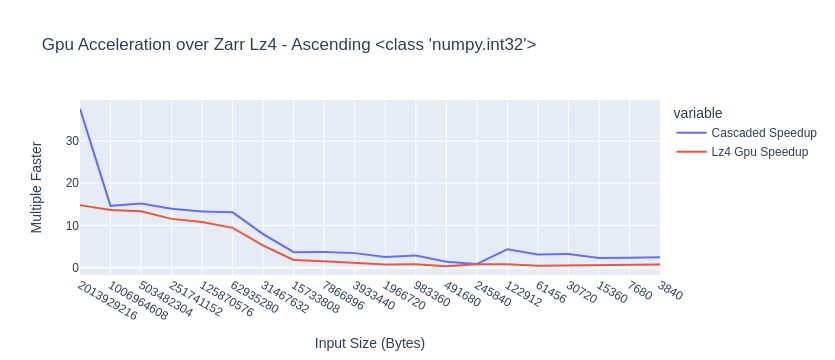

In [60]:
import plotly.express as px
title = 'Gpu Acceleration over Zarr Lz4 - ' + TARGET + " " + str(DTYPE)
subtitle = 'Includes host->gpu copy time'
fig = px.line(df, x='Input Size (Bytes)',
              y=['Cascaded Speedup', 'Lz4 Gpu Speedup'],
              labels={'value': 'Multiple Faster'},
              title=title)
fig.update_xaxes(type='category')
fig.show()

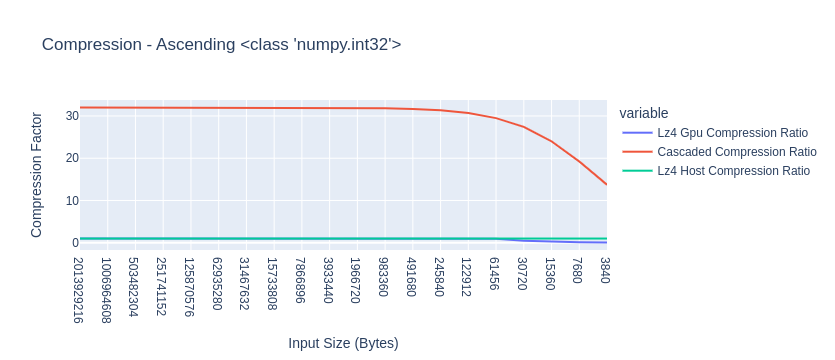

In [61]:
import plotly.express as px
title = 'Compression - ' + TARGET + " " + str(DTYPE)
fig = px.line(df, x='Input Size (Bytes)',
              y=[
                  'Lz4 Gpu Compression Ratio',
                  'Cascaded Compression Ratio',
                  'Lz4 Host Compression Ratio'
              ],
              labels={'value': 'Compression Factor'},
              title=title)
fig.update_xaxes(type='category')
fig.show()

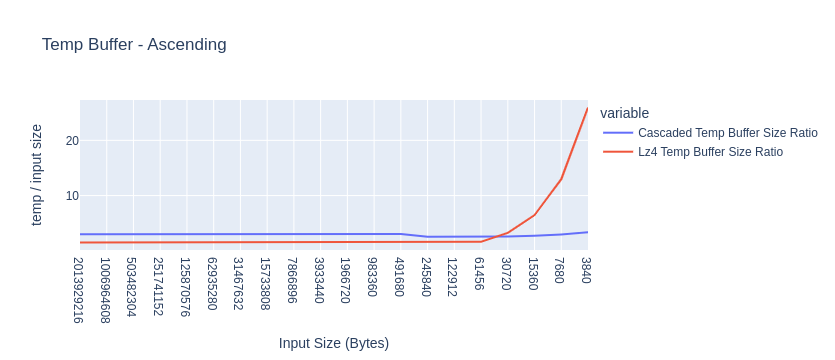

In [62]:
import plotly.express as px
title = 'Temp Buffer - ' + TARGET
fig = px.line(df, x='Input Size (Bytes)',
              y=[
                  'Cascaded Temp Buffer Size Ratio',
                  'Lz4 Temp Buffer Size Ratio'
              ],
              labels={'value': 'temp / input size'},
              title=title)
fig.update_xaxes(type='category')
fig.show()